In [1]:
import numpy as np 
from qiskit import *

Opaque Gates

In [2]:
from qiskit.circuit import Gate

my_gate = Gate(name = 'my_gate', num_qubits= 2, params= [])

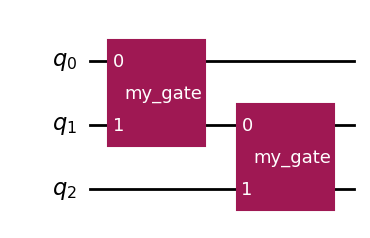

In [8]:
qr = QuantumRegister(3, 'q')
circ = QuantumCircuit(qr)

circ.append(my_gate, [qr[0], qr[1]])
circ.append(my_gate, [qr[1], qr[2]])

circ.draw('mpl')

Composite Gates

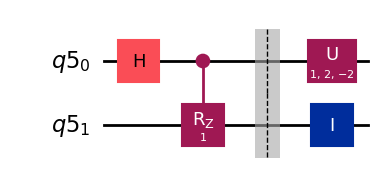

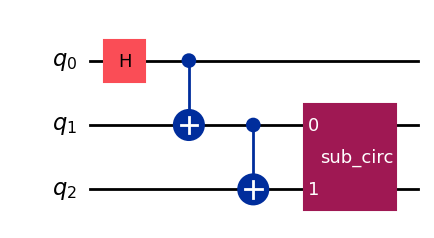

In [14]:
# Build a sub-circuit

sub_q = QuantumRegister(2)
sub_circ = QuantumCircuit(sub_q, name = 'sub_circ')

sub_circ.h(sub_q[0])
sub_circ.crz(1, sub_q[0], sub_q[1])
sub_circ.barrier()
sub_circ.id(sub_q[1])
sub_circ.u(1, 2, -2, sub_q[0])

display(sub_circ.draw('mpl'))

# Convert to a gate and stick into an arbitrary place in the bigger circuit
sub_inst = sub_circ.to_instruction()

qr = QuantumRegister(3, 'q')
circ = QuantumCircuit(qr)
circ.h(qr[0])
circ.cx(qr[0], qr[1])
circ.cx(qr[1], qr[2])
circ.append(sub_inst, [qr[1], qr[2]])

circ.draw('mpl')

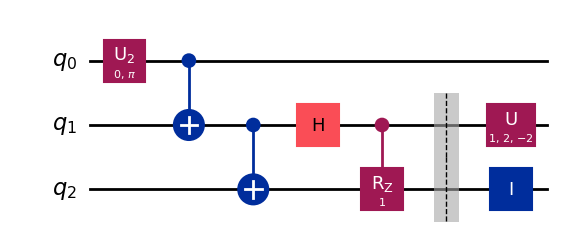

In [13]:
decomposed_circ = circ.decompose()
decomposed_circ.draw('mpl')

Parameterized Circuits

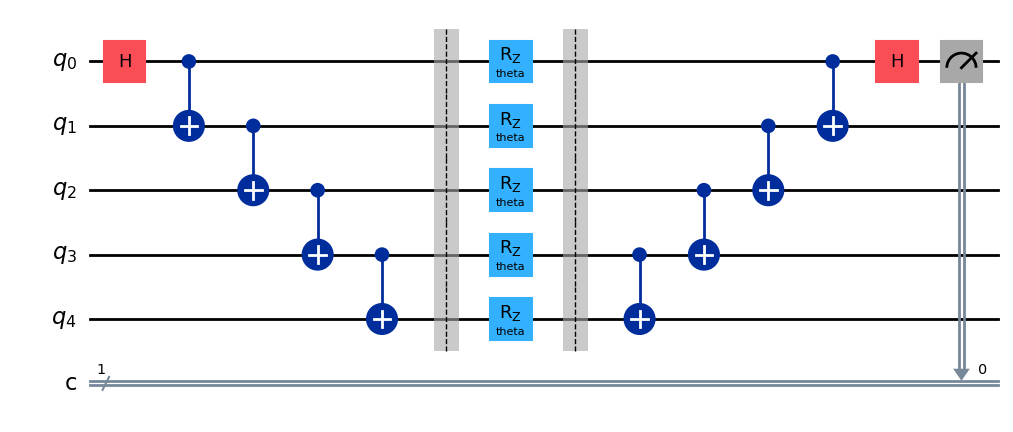

In [19]:
from qiskit.circuit import Parameter

theta = Parameter('theta')
n = 5 

qc = QuantumCircuit(5, 1)

qc.h(0)
for i in range(n - 1): 
    qc.cx(i, i + 1)

qc.barrier()
qc.rz(theta, range(5))
qc.barrier() 

for i in reversed(range(n-1)): 
    qc.cx(i, i + 1)

qc.h(0)
qc.measure(0, 0)

qc.draw('mpl')

In [20]:
print(qc.parameters)

ParameterView([Parameter(theta)])


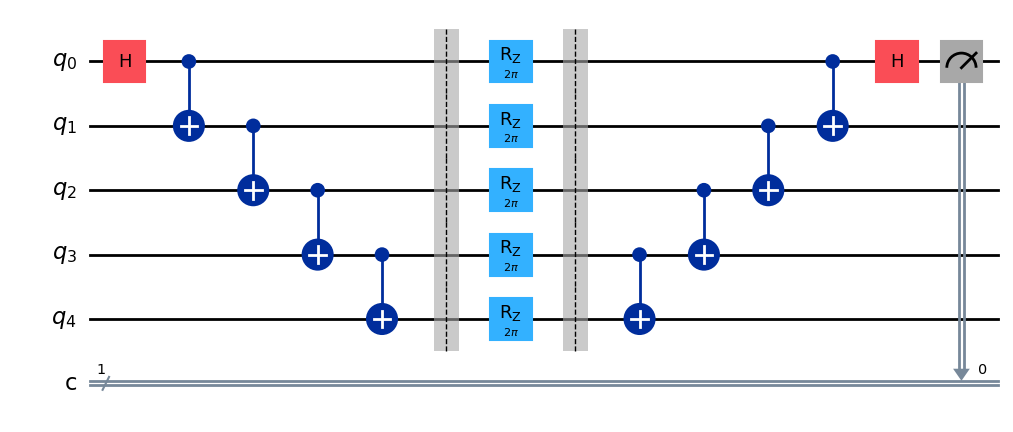

In [28]:
theta_range = np.linspace(0, 2 * np.pi, 128)

circuits = [qc.assign_parameters({theta: theta_val}) for theta_val in theta_range]

circuits[-1].draw('mpl')


In [37]:
from qiskit_aer import QasmSimulator

backend = QasmSimulator()
job = backend.run(transpile(circuits, backend))
counts = job.result().get_counts()


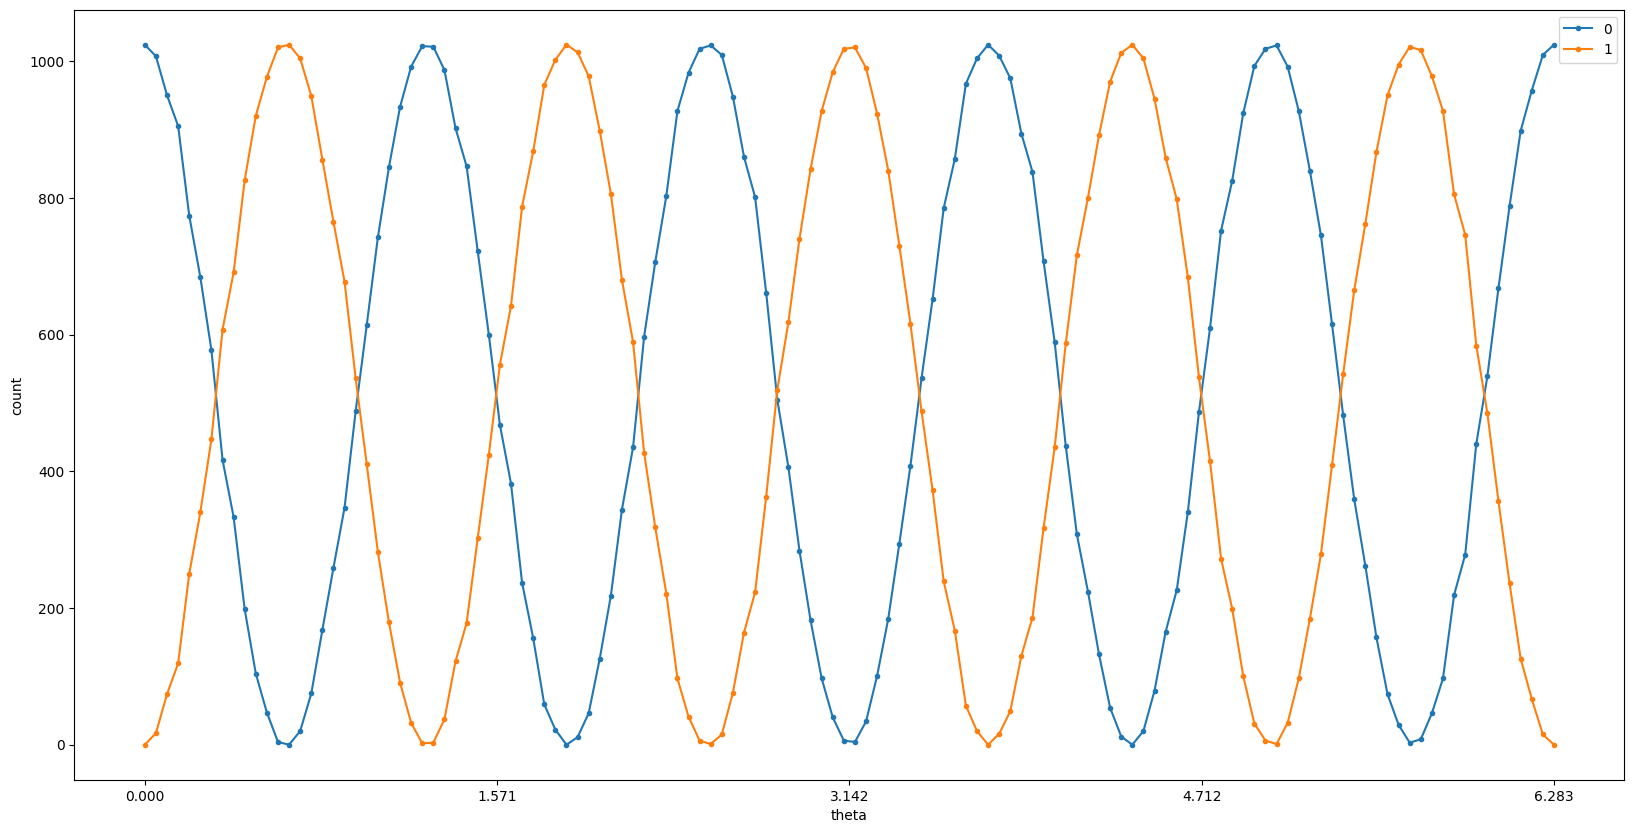

In [39]:
import matplotlib.pyplot as plt 

fig, ax = plt.subplots(1, 1, figsize = (20, 10))

ax.plot(theta_range, list(map(lambda c: c.get('0', 0), counts)), '.-', label = '0')
ax.plot(theta_range, list(map(lambda c: c.get('1', 0), counts)), '.-', label = '1')

ax.set_xticks([i * np.pi / 2 for i in range(5)])
ax.set_xlabel('theta')
ax.set_ylabel('count')
ax.legend()

Reducing complication cost

Compiling over a parameterized circuit prior to assining can, in some cases, significantly reduce compilation time as compared to compiling over a set of bound circuits

In [41]:
import time 
from itertools import combinations 
from qiskit.compiler import assemble
from qiskit.providers.fake_provider import Fake5QV1

In [49]:
start = time.time()
qcs = []

theta_range = np.linspace(0, 2*np.pi, 32)

for n in theta_range:
    qc = QuantumCircuit(5)

    for k in range(8):
        for i, j in combinations(range(5), 2): 
            qc.cx(i, j)
        qc.rz(n, range(5))
        for i,j in combinations(range(5), 2): 
            qc.cx(i,j)

    qcs.append(qc)

compiled_circuits = transpile(qcs, backend = Fake5QV1())
qobj = assemble(compiled_circuits, backend = Fake5QV1())

end = time.time()
print('Time compiling over set of bound circuits ', end-start)


Time compiling over set of bound circuits  0.8334090709686279


In [61]:
start = time.time()
qc = QuantumCircuit(5)

theta = Parameter('theta')

for k in range(8): 
    for i,j in combinations(range(5), 2): 
        qc.cx(i, j)
    qc.rz(theta, range(5))
    for i,j in combinations(range(5), 2): 
        qc.cx(i, j)

transpiled_qc = transpile(qc, backend = Fake5QV1())
qobj = assemble([transpiled_qc.assign_parameters({theta: n}) 
                 for n in theta_range], backend = Fake5QV1())

end = time.time()
print('Time compiling over parameterized circuit, then binding: ', end-start)

Time compiling over parameterized circuit, then binding:  0.0447077751159668


Composition

Parameterized circuits can be composed like standard QuantumCircuits. When composing two parameterized circuits, the resulting circuit will be parameterized by the union of the parameters of the input circuits. 

Parameter names must be unique. 

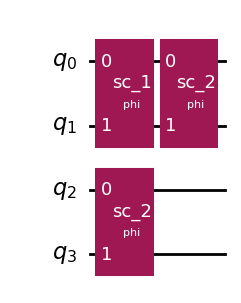

In [63]:
phi = Parameter('phi')

sub_circ1 = QuantumCircuit(2, name = 'sc_1')
sub_circ1.rz(phi, 0)
sub_circ1.rz(phi, 1)

sub_circ2 = QuantumCircuit(2, name = 'sc_2')
sub_circ2.rz(phi, 0)
sub_circ2.rz(phi, 1)

qc = QuantumCircuit(4)
qr = qc.qregs[0]

qc.append(sub_circ1.to_instruction(), [qr[0], qr[1]])
qc.append(sub_circ2.to_instruction(), [qr[0], qr[1]])

qc.append(sub_circ2.to_instruction(), [qr[2], qr[3]])

qc.draw('mpl')

To insert a subcircuit with a different parameterization, the `to_instruction` method accepts an argument `parameter_map` which generates instructions within the source parameter replaced by the new parameter. 

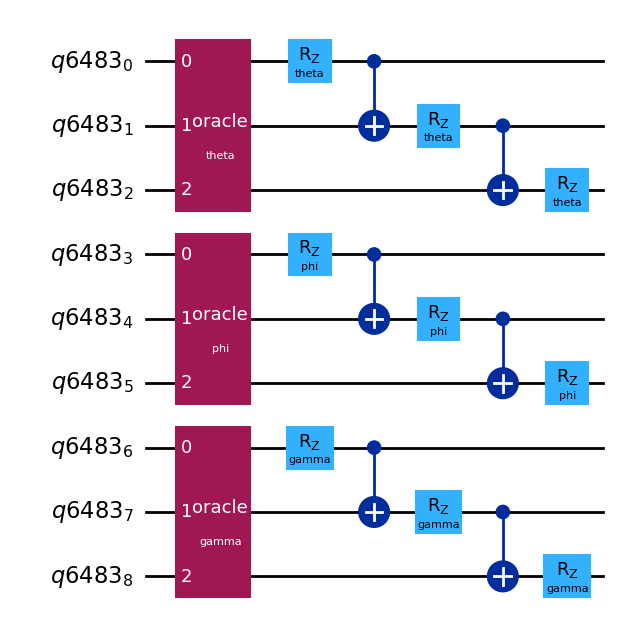

In [73]:
p = Parameter('p')

qc=  QuantumCircuit(3, name = 'oracle')
qc.rz(p, 0)
qc.cx(0, 1)
qc.rz(p, 1)
qc.cx(1, 2)
qc.rz(p, 2)

theta = Parameter('theta')
phi = Parameter('phi')
gamma = Parameter('gamma')

qr = QuantumRegister(9)

larger_qc = QuantumCircuit(qr)
larger_qc.append(qc.to_instruction({p: theta}), qr[0:3])
larger_qc.append(qc.to_instruction({p: phi}), qr[3:6])
larger_qc.append(qc.to_instruction({p: gamma}), qr[6:9])

circ = larger_qc.compose(larger_qc.decompose(), qr[0:9])
circ.draw('mpl')
